In [80]:
import os
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode, tools_condition
import yfinance as yf
from IPython.display import Image, display

### Configuring Model 

In [2]:
os.getenv('GROQ_API_KEY')

'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'

In [3]:
model = 'deepseek-r1-distill-llama-70b'

In [4]:
llm = ChatGroq(model_name=model, temperature=0)

In [5]:
response = llm.invoke("What is the length of wall of China?")

In [6]:
response.content

"<think>\nOkay, so I need to figure out the length of the Great Wall of China. I remember hearing that it's really long, but I'm not exactly sure how long. I think it's somewhere in the thousands of kilometers, but I'm not certain. Let me try to break this down.\n\nFirst, I know the Great Wall is a series of fortifications built across several Chinese dynasties to protect the borders. It's not just one continuous wall but made up of different sections built at different times. So, the total length would be the sum of all these sections.\n\nI've heard different numbers before. Some people say it's about 13,000 miles, others say it's around 21,000 kilometers. Wait, that seems like a big difference. Maybe it's because some sources include all the branches and sections, while others just count the main parts.\n\nI should consider the units. 13,000 miles converted to kilometers would be around 20,920 km, which is close to 21,000 km. So maybe both figures are referring to the same total leng

### Custom Tool

In [10]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

### Inbuilt Tool

In [ ]:
search = DuckDuckGoSearchRun()

In [9]:
search.invoke("What is the current trensing news?")

"Live updates on today's local & national top stories: politics, entertainment, sports, health & safety news with summaries, numbers, videos, and news facts. NPR news, audio, and podcasts. Coverage of breaking stories, national and world news, politics, business, science, technology, and extended coverage of major national and world events. The United States on Sunday targeted three nuclear sites in Iran, as it intervened in the ongoing conflict between the Islamic Republic and Israel and triggered fears of dangerous escalation of ... Live news, investigations, opinion, photos and video by the journalists of The New York Times from more than 150 countries around the world. Subscribe for coverage of U.S. and international news ... You'll find the latest prices and price changes for the Nasdaq, S&P 500 and the Dow Jones Industrial Average, as well as for the Russell 2000. Track Stock Futures For The Dow Jones, S&P 500 And Nasdaq"

### Tool Binding

In [11]:
tools=[multiply, add, divide, search]

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
response = llm_with_tools.invoke("Hi")

In [15]:
response.content

'Hello! How can I assist you today?'

In [16]:
response.tool_calls

[]

In [17]:
response = llm_with_tools.invoke("what is 2+2?")

In [18]:
response.content

''

In [19]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '17ft0z818',
  'type': 'tool_call'}]

### Orchestration (Designing Workflow)

In [46]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."

In [47]:
user_query=["tell me what is 2+2"]

In [48]:
def function_1(state:MessagesState):
    
    user_question = state['messages']

    input_question = [SYSTEM_PROMPT]+user_question

    response = llm_with_tools.invoke(input_question) 

    return {
        "messages":[response]
    }

In [49]:
builder = StateGraph(MessagesState)

In [50]:
builder.add_node('llm_decision_step', function_1)

In [51]:
builder.add_node('tools', ToolNode(tools))

In [52]:
builder.add_edge(START, 'llm_decision_step')

In [53]:
builder.add_conditional_edges('llm_decision_step',
                              tools_condition,)

The tools_condition function in LangGraph is used to determine the next node in a graph based on whether a tool call is needed or if the process should end. It is commonly used in conditional edges to route the flow of the graph.

In [54]:
builder.add_edge('tools', 'llm_decision_step')

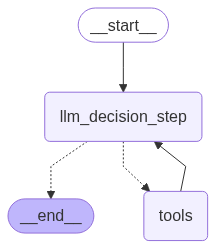

In [55]:
builder.compile()

In [56]:
react_agent = builder.compile()

In [57]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]

In [61]:
response = react_agent.invoke({"messages":message})

In [62]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (fjsytthq3)
 Call ID: fjsytthq3
  Args:
    query: Narendra Modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi (born September 17, 1950, Vadnagar, India) is an Indian politician and government official who rose to become a senior leader of the Bharatiya Janata Party (BJP). In 2014 he led his party to victory in elections to the Lok Sabha (lower chamber of the Indian parliament), after which he was sworn in as prime minister of India.Prior to that he had served (2001-14) as chief ... List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jawaharlal Nehru is the first and the longest ... Nare

### Adding one more Inbuilt Tool

In [64]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [66]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $196.58.'

In [67]:
tools = [add, multiply, divide, search, get_stock_price]

In [68]:
llm_with_tools=llm.bind_tools(tools)

In [69]:
response = llm_with_tools.invoke("can you give me the latest stock price of adani greens?")

In [70]:
response.content

''

In [71]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': 'vz8c8v2yq',
  'type': 'tool_call'}]

In [73]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [74]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

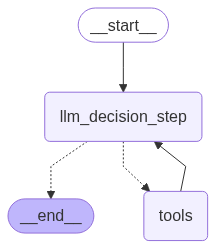

In [77]:
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))

In [78]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [79]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (bnmb0qkvx)
 Call ID: bnmb0qkvx
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $196.58.
================================== Ai Message ==================================
Tool Calls:
  add (z9jst35gg)
 Call ID: z9jst35gg
  Args:
    a: 1000
    b: 196
================================= Tool Message =================================
Name: add

1196
================================== Ai Message ==================================

The sum of 1000 and the current stock price of Apple (AAPL) is **1196.58**.
